<a href="https://colab.research.google.com/github/mateusmartinsperes/Curso-Python-Gustavo-Guanabara/blob/master/fuzzy_solos_mamdani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lógica Fuzzy aplicada à modelagem do fluxo de água em solos (Mamdani)**

Este notebook reproduz (de forma independente) o **Sistema de Inferência Fuzzy (Mamdani)** apresentado na dissertação:

**AFONSO, Antônio Cláudio Marques (2009). _Lógica fuzzy aplicada à modelagem da transferência de água em solos_. UFPE.**

O trabalho propõe dois modelos fuzzy (Caso 1 e Caso 2) para aproximar a dinâmica do **fluxo vertical de água na zona não saturada do solo** (modelo de referência: solução numérica da equação de Richards), usando regras fuzzy que dependem apenas das umidades (grau de saturação) em duas camadas adjacentes.


In [2]:
# [1] Instalação do pacote (no Colab)
!pip -q install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.4 MB/s eta 0:00:00


# **Sistema Fuzzy (problema do trabalho)**

**Problema:** descrever o **fluxo vertical não saturado** no solo através de um modelo simples e transparente, reduzindo a dependência de parâmetros difíceis de medir.

**Ideia central do modelo fuzzy (Afonso, 2009):**
- Entradas: **grau de saturação** em dois pontos adjacentes do perfil do solo (**P1** e **P2**), normalizado no intervalo **[0, 1]**.
- Saída: **densidade de fluxo** entre P1 e P2 (**fluxo**, em cm/h).
- Estrutura: **7 conjuntos fuzzy** para cada variável e **49 regras**.
- Inferência: **Mamdani** (operador *min* para AND e *max* para agregação).
- Defuzzificação: **centro de gravidade (centroid)**.


# **Fuzzificação**
Nesta etapa:
1. Definimos as variáveis linguísticas **P1**, **P2** (entradas) e **fluxo** (saída);
2. Definimos **funções de pertinência triangulares** (Figuras 10–15 do trabalho);
3. Montamos os **conjuntos fuzzy** (MMB, MB, B, M, LA, A, MA).

In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def configurar_saida_fluxo(fluxo, caso: int, solo: str) -> None:
    """Define as funções de pertinência do Fluxo (densidade de fluxo), conforme Figuras 12–15.

    solo:
      - 'silte_columbia'  (caso 1 e caso 2)
      - 'franco_arenoso'  (caso 1)
      - 'areia_grenoble'  (caso 2)
    """
    # Domínios aproximados observados nas figuras do trabalho
    if caso == 1 and solo == 'silte_columbia':
        U = fluxo.universe
        fluxo['MMB'] = fuzz.trimf(U, [0.00, 0.00, 0.06])
        fluxo['MB']  = fuzz.trimf(U, [0.05, 0.06, 0.07])
        fluxo['B']   = fuzz.trimf(U, [0.06, 0.075, 0.09])
        fluxo['M']   = fuzz.trimf(U, [0.08, 0.095, 0.11])
        fluxo['LA']  = fuzz.trimf(U, [0.11, 0.12, 0.16])
        fluxo['A']   = fuzz.trimf(U, [0.12, 0.155, 0.18])
        fluxo['MA']  = fuzz.trimf(U, [0.14, 0.18, 0.18])

    elif caso == 1 and solo == 'franco_arenoso':
        U = fluxo.universe
        fluxo['MMB'] = fuzz.trimf(U, [0.00, 0.00, 0.35])
        fluxo['MB']  = fuzz.trimf(U, [0.30, 0.40, 0.50])
        fluxo['B']   = fuzz.trimf(U, [0.40, 0.50, 0.60])
        fluxo['M']   = fuzz.trimf(U, [0.50, 0.65, 0.80])
        fluxo['LA']  = fuzz.trimf(U, [0.70, 0.80, 1.10])
        fluxo['A']   = fuzz.trimf(U, [0.80, 1.00, 1.20])
        fluxo['MA']  = fuzz.trimf(U, [0.90, 1.20, 1.20])

    elif caso == 2 and solo == 'silte_columbia':
        U = fluxo.universe
        fluxo['MMB'] = fuzz.trimf(U, [0.00, 0.00, 0.03])
        fluxo['MB']  = fuzz.trimf(U, [0.02, 0.035, 0.05])
        fluxo['B']   = fuzz.trimf(U, [0.03, 0.06, 0.08])
        fluxo['M']   = fuzz.trimf(U, [0.07, 0.10, 0.12])
        fluxo['LA']  = fuzz.trimf(U, [0.11, 0.13, 0.15])
        fluxo['A']   = fuzz.trimf(U, [0.14, 0.16, 0.18])
        fluxo['MA']  = fuzz.trimf(U, [0.17, 0.20, 0.20])

    elif caso == 2 and solo == 'areia_grenoble':
        U = fluxo.universe
        fluxo['MMB'] = fuzz.trimf(U, [0.0, 0.0, 1.0])
        fluxo['MB']  = fuzz.trimf(U, [0.8, 1.0, 1.2])
        fluxo['B']   = fuzz.trimf(U, [1.0, 1.5, 2.0])
        fluxo['M']   = fuzz.trimf(U, [1.8, 2.5, 3.0])
        fluxo['LA']  = fuzz.trimf(U, [2.8, 3.2, 4.0])
        fluxo['A']   = fuzz.trimf(U, [3.5, 4.0, 4.7])
        fluxo['MA']  = fuzz.trimf(U, [4.3, 5.0, 5.0])
    else:
        raise ValueError('Combinação caso/solo não suportada.')

RULES_CASE1 = [
    (1, 'MMB', 'MMB', 'MMB'),
    (2, 'MMB', 'MB', 'MMB'),
    (3, 'MMB', 'MA', 'MMB'),
    (4, 'MMB', 'A', 'MMB'),
    (5, 'MMB', 'B', 'MMB'),
    (6, 'MMB', 'M', 'MMB'),
    (7, 'MMB', 'LA', 'MMB'),
    (8, 'MB', 'MB', 'MB'),
    (9, 'MB', 'B', 'B'),
    (10, 'MB', 'MMB', 'MMB'),
    (11, 'MB', 'MA', 'MB'),
    (12, 'MB', 'M', 'MB'),
    (13, 'MB', 'LA', 'MB'),
    (14, 'MB', 'A', 'MB'),
    (15, 'B', 'B', 'B'),
    (16, 'B', 'M', 'M'),
    (17, 'B', 'MB', 'B'),
    (18, 'B', 'MA', 'B'),
    (19, 'B', 'MMB', 'MMB'),
    (20, 'B', 'LA', 'M'),
    (21, 'B', 'A', 'M'),
    (22, 'M', 'M', 'M'),
    (23, 'M', 'LA', 'LA'),
    (24, 'M', 'B', 'M'),
    (25, 'M', 'MA', 'LA'),
    (26, 'M', 'MMB', 'MMB'),
    (27, 'M', 'MB', 'MB'),
    (28, 'M', 'A', 'LA'),
    (29, 'LA', 'LA', 'LA'),
    (30, 'LA', 'MA', 'A'),
    (31, 'LA', 'A', 'A'),
    (32, 'LA', 'M', 'LA'),
    (33, 'LA', 'MMB', 'MMB'),
    (34, 'LA', 'MB', 'MB'),
    (35, 'LA', 'B', 'M'),
    (36, 'A', 'A', 'A'),
    (37, 'A', 'MA', 'MA'),
    (38, 'A', 'LA', 'A'),
    (39, 'A', 'MMB', 'MMB'),
    (40, 'A', 'MB', 'MB'),
    (41, 'A', 'B', 'M'),
    (42, 'A', 'M', 'LA'),
    (43, 'MA', 'MA', 'MA'),
    (44, 'MA', 'A', 'MA'),
    (45, 'MA', 'LA', 'A'),
    (46, 'MA', 'MMB', 'MMB'),
    (47, 'MA', 'MB', 'MB'),
    (48, 'MA', 'B', 'B'),
    (49, 'MA', 'M', 'LA'),
]

RULES_CASE2 = [
    (1, 'MMB', 'MMB', 'MMB'),
    (2, 'MMB', 'MB', 'MMB'),
    (3, 'MMB', 'MA', 'MMB'),
    (4, 'MMB', 'A', 'MMB'),
    (5, 'MMB', 'B', 'MMB'),
    (6, 'MMB', 'M', 'MMB'),
    (7, 'MMB', 'LA', 'MMB'),
    (8, 'MB', 'MB', 'MB'),
    (9, 'MB', 'B', 'B'),
    (10, 'MB', 'MMB', 'MMB'),
    (11, 'MB', 'MA', 'B'),
    (12, 'MB', 'M', 'B'),
    (13, 'MB', 'LA', 'B'),
    (14, 'MB', 'A', 'B'),
    (15, 'B', 'B', 'B'),
    (16, 'B', 'M', 'M'),
    (17, 'B', 'MB', 'B'),
    (18, 'B', 'MA', 'M'),
    (19, 'B', 'MMB', 'MMB'),
    (20, 'B', 'LA', 'M'),
    (21, 'B', 'A', 'M'),
    (22, 'M', 'M', 'M'),
    (23, 'M', 'LA', 'LA'),
    (24, 'M', 'B', 'M'),
    (25, 'M', 'MA', 'LA'),
    (26, 'M', 'MMB', 'MMB'),
    (27, 'M', 'MB', 'B'),
    (28, 'M', 'A', 'LA'),
    (29, 'LA', 'LA', 'LA'),
    (30, 'LA', 'MA', 'A'),
    (31, 'LA', 'A', 'A'),
    (32, 'LA', 'M', 'LA'),
    (33, 'LA', 'MMB', 'MMB'),
    (34, 'LA', 'MB', 'B'),
    (35, 'LA', 'B', 'M'),
    (36, 'A', 'A', 'A'),
    (37, 'A', 'MA', 'MA'),
    (38, 'A', 'LA', 'A'),
    (39, 'A', 'MMB', 'MMB'),
    (40, 'A', 'MB', 'B'),
    (41, 'A', 'B', 'M'),
    (42, 'A', 'M', 'LA'),
    (43, 'MA', 'MA', 'MA'),
    (44, 'MA', 'A', 'MA'),
    (45, 'MA', 'LA', 'A'),
    (46, 'MA', 'MMB', 'MMB'),
    (47, 'MA', 'MB', 'B'),
    (48, 'MA', 'B', 'M'),
    (49, 'MA', 'M', 'LA'),
]


def criar_sistema(caso: int, solo: str):
    """Cria o sistema de inferência fuzzy (Mamdani) para um caso e um solo."""
    P1 = ctrl.Antecedent(np.arange(0, 1.001, 0.001), 'P1')
    P2 = ctrl.Antecedent(np.arange(0, 1.001, 0.001), 'P2')

    # Define o universo da saída conforme o solo/caso
    if caso == 1 and solo == 'silte_columbia':
        fluxo = ctrl.Consequent(np.arange(0, 0.181, 0.001), 'fluxo')
    elif caso == 1 and solo == 'franco_arenoso':
        fluxo = ctrl.Consequent(np.arange(0, 1.201, 0.001), 'fluxo')
    elif caso == 2 and solo == 'silte_columbia':
        fluxo = ctrl.Consequent(np.arange(0, 0.201, 0.001), 'fluxo')
    elif caso == 2 and solo == 'areia_grenoble':
        fluxo = ctrl.Consequent(np.arange(0, 5.001, 0.01), 'fluxo')
    else:
        raise ValueError('Combinação caso/solo não suportada.')

    # Entradas
    # Funções de pertinência (triangulares) para as entradas (grau de saturação em [0,1])
    # Observação: os parâmetros abaixo foram aproximados a partir das Figuras 10 e 11 da dissertação.
    P1['MMB'] = fuzz.trimf(P1.universe, [0.00, 0.00, 0.45])
    P1['MB']  = fuzz.trimf(P1.universe, [0.38, 0.48, 0.58])
    P1['B']   = fuzz.trimf(P1.universe, [0.48, 0.60, 0.72])
    P1['M']   = fuzz.trimf(P1.universe, [0.62, 0.72, 0.82])
    P1['LA']  = fuzz.trimf(P1.universe, [0.70, 0.78, 0.86])
    P1['A']   = fuzz.trimf(P1.universe, [0.76, 0.84, 0.92])
    P1['MA']  = fuzz.trimf(P1.universe, [0.88, 1.00, 1.00])

    # As entradas P2 usam os mesmos conjuntos fuzzy (conforme descrito na Seção 3.5).
    for k in P1.terms:
        P2[k] = P1[k].mf# Saída
    configurar_saida_fluxo(fluxo, caso=caso, solo=solo)

    # Regras
    regras_raw = RULES_CASE1 if caso == 1 else RULES_CASE2
    regras = []
    for _, a, b, c in regras_raw:
        regras.append(ctrl.Rule(P1[a] & P2[b], fluxo[c]))

    sistema = ctrl.ControlSystem(regras)
    sim = ctrl.ControlSystemSimulation(sistema)
    return P1, P2, fluxo, sim

# **Inferência Fuzzy (Mamdani) e Defuzzificação**

A base de regras do trabalho é do tipo:

> **SE** (P1 é X) **E** (P2 é Y) **ENTÃO** (Fluxo é Z)

onde X, Y, Z ∈ {MMB, MB, B, M, LA, A, MA}.  
Cada caso possui uma base com **49 regras** (Seção 3.4).

In [5]:
# Exemplo de simulação
caso = 1
solo = 'silte_columbia'  # 'silte_columbia' | 'franco_arenoso' | 'areia_grenoble'
P1, P2, fluxo, sim = criar_sistema(caso=caso, solo=solo)

# Defina as entradas (grau de saturação em [0,1])
sim.input['P1'] = 0.78
sim.input['P2'] = 0.62

sim.compute()
print(f"Fluxo defuzzificado (caso={caso}, solo={solo}): {sim.output['fluxo']:.5f} cm/h")

Fluxo defuzzificado (caso=1, solo=silte_columbia): 0.09500 cm/h


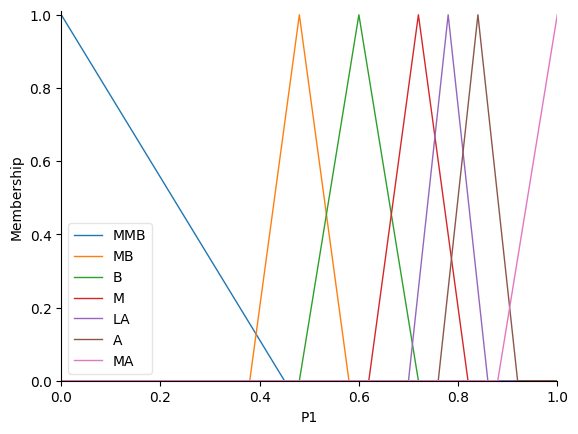

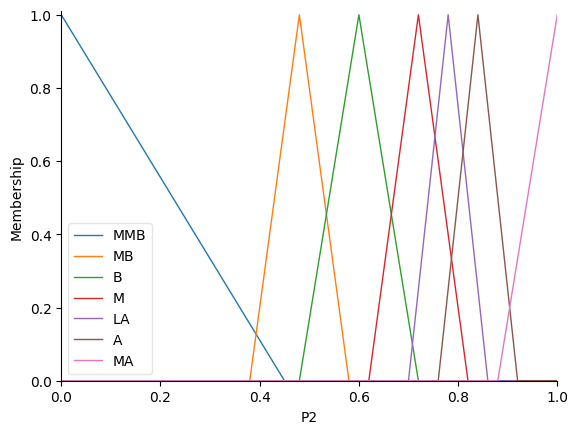

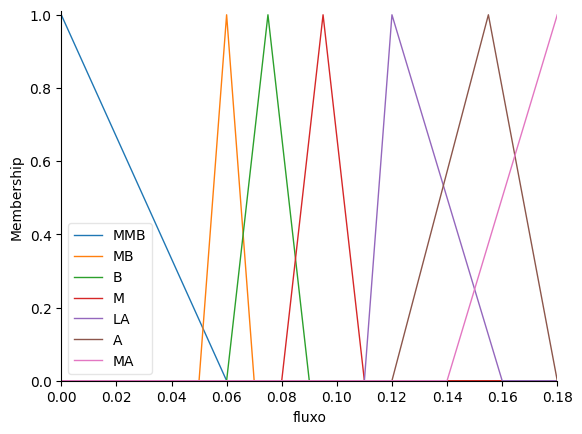

In [6]:
# Visualização das funções de pertinência (entradas e saída)
P1.view()
P2.view()
fluxo.view()

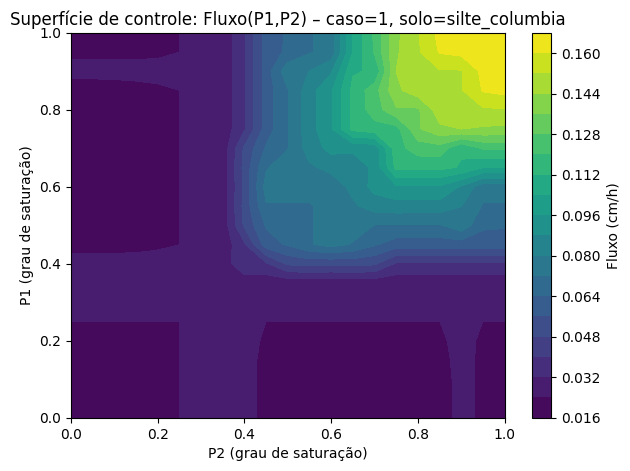

In [7]:
# Superfície de controle (Fluxo(P1,P2)) para visualizar o comportamento do sistema
import matplotlib.pyplot as plt

def superficie_controle(caso: int, solo: str, step=0.02):
    P1_, P2_, fluxo_, sim_ = criar_sistema(caso=caso, solo=solo)
    x = np.arange(0, 1.0001, step)
    y = np.arange(0, 1.0001, step)
    Z = np.zeros((len(x), len(y)))

    for i, xv in enumerate(x):
        for j, yv in enumerate(y):
            sim_.input['P1'] = float(xv)
            sim_.input['P2'] = float(yv)
            sim_.compute()
            Z[i, j] = sim_.output['fluxo']

    X, Y = np.meshgrid(y, x)
    plt.figure(figsize=(7,5))
    plt.contourf(X, Y, Z, levels=20)
    plt.xlabel("P2 (grau de saturação)")
    plt.ylabel("P1 (grau de saturação)")
    plt.title(f"Superfície de controle: Fluxo(P1,P2) – caso={caso}, solo={solo}")
    plt.colorbar(label="Fluxo (cm/h)")
    plt.show()

superficie_controle(caso=1, solo='silte_columbia', step=0.05)

## Observações finais
- Este notebook **não utiliza códigos dos autores**: a implementação foi escrita do zero.
- Os parâmetros numéricos das funções de pertinência foram **aproximados visualmente** a partir das Figuras 10–15.
- Para uma reprodução ainda mais fiel, você pode ajustar os pontos das funções triangulares até coincidir com as figuras.
